# Full Stats, Haccytrees
This notebook will be like a combination of Haccytrees.ipynb and LJ-Full_Fossil_Groups.ipynb. After this one is finished, those notebooks may be cleaned up or deleted

## Set Up

In [1]:
import h5py
import pickle
import numpy as np
import numba
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import haccytrees.mergertrees
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from itertools import groupby
from matplotlib.ticker import ScalarFormatter
%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_func_haccytrees

plt.rcParams.update({
    "text.usetex": True,
    'font.size': 13,
    "figure.figsize": (6, 3.5)
})

pyfftw not available, using numpy fft


In [2]:
%%time
forest, progenitor_array = haccytrees.mergertrees.read_forest(
    '/data/a/cpac/mbuehlmann/LastJourney/forest/target_forest_aurora.hdf5',
    'LastJourney', nchunks=1, chunknum=0, mass_threshold = 2.7*10**11,
    include_fields = ["tree_node_mass", "snapnum", "fof_halo_tag", "sod_halo_cdelta", "fof_halo_center_x", "fof_halo_center_y", "fof_halo_center_z"]
)

CPU times: user 8.7 s, sys: 32.6 s, total: 41.3 s
Wall time: 5min 14s


In [3]:
%%time
fg_forest, fg_progenitor_array = haccytrees.mergertrees.read_forest(
    "/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest.hdf5",
    'LastJourney',
    mass_threshold=2.7*10**11
)

CPU times: user 36.7 s, sys: 4min, total: 4min 37s
Wall time: 7min 52s


In [4]:
fg_forest.keys()

dict_keys(['branch_size', 'desc_node_index', 'fof_halo_center_x', 'fof_halo_center_y', 'fof_halo_center_z', 'fof_halo_count', 'fof_halo_mass', 'fof_halo_tag', 'snapnum', 'sod_halo_cdelta', 'sod_halo_cdelta_accum', 'sod_halo_cdelta_error', 'sod_halo_cdelta_peak', 'sod_halo_count', 'sod_halo_mass', 'sod_halo_radius', 'tree_node_index', 'tree_node_mass', 'xoff_com', 'xoff_fof', 'xoff_sod', 'scale_factor', 'descendant_idx', 'progenitor_count', 'progenitor_offset', 'halo_index'])

In [5]:
sim = haccytrees.Simulation.simulations['LastJourney']
redshifts = np.flip(sim.step2z(np.array(sim.cosmotools_steps)))

In [6]:
%%time
mlim = [1e13, 1e14] # Should yield 307993 from the random sample
xaxis = 'snap_nums'
absolute_threshold = True
threshold = 5e11
z_thresh = 1
norm_tf = False
restrict_mass = True
use_sigma = True
mrich_thresh = 0.1
# Go find yourself some fossil groups!
target_idx = help_func_haccytrees.find_halos(forest, mlim)
mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(target_idx, forest)
mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(forest, progenitor_array, mainbranch_index, absolute_threshold)
major_mergers = help_func_haccytrees.get_major_mergers(mainbranch_mergers, threshold)
lmm_redshifts = help_func_haccytrees.get_lmms(major_mergers, threshold)
fgs, rugs, mrich = help_func_haccytrees.find_specials(forest, mainbranch_index, major_mergers, lmm_redshifts, target_idx, z_thresh, mrich_thresh = mrich_thresh, restrict_mass = restrict_mass, use_sigma = use_sigma, mainbranch_masses = mainbranch_masses)
print(len(target_idx), " halos")
print(len(fgs), " fossils")
print(len(rugs), " rugs")
print(len(mrich), " merger rich halos")

307993  halos
34946  fossils
4180  rugs
26937  merger rich halos
CPU times: user 3.21 s, sys: 3.34 s, total: 6.55 s
Wall time: 2.62 s


## Mass Matching/Narrow Bins

In [7]:
# Make masks
fg_masks = help_func_haccytrees.make_masks(fg_forest)
halo_masks = help_func_haccytrees.make_masks(forest)#, target_idx = target_idx)

## Go find QH Candidates

In [8]:
qh_masks = []
for this_mask in (fg_masks):
    fg_idx = np.nonzero(this_mask)[0]
    mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(fg_idx, fg_forest)
    mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(fg_forest, fg_progenitor_array, mainbranch_index)
    major_mergers = help_func_haccytrees.get_major_mergers(mainbranch_mergers)
    lmm_redshift = help_func_haccytrees.get_lmms(major_mergers)
    fgs, qhs, mrich = help_func_haccytrees.find_specials(fg_forest, mainbranch_index, major_mergers, lmm_redshift, fg_idx)
    # This qhs index will be an index associated with this specific mass bin/this fg mask. Is there any reason to have a mask version? Maybe, because of later...
    qh_mask = np.zeros_like(this_mask)
    qh_mask[qhs] = 1
    qh_masks.append(qh_mask)

## zfracs: dp(z) / dz

count1
count:  0.5


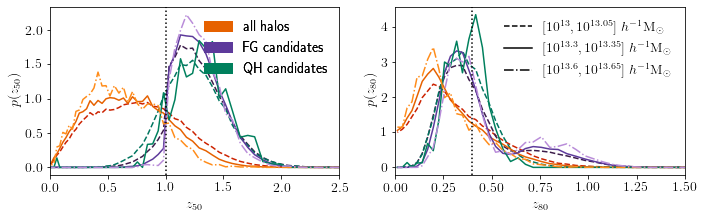

In [11]:
plt.rcParams.update({
    'font.size': 14,
    "figure.figsize": (5.4, 3.25), #(5.2, 3.13), #(5.4, 3.25), #(5.83, 3.5),#(6.25, 4.25), #(6.25, 3.75)
})

sim = haccytrees.Simulation.simulations['LastJourney']
zsteps = sim.step2z(np.array(sim.cosmotools_steps))
zmean = 0.5*(zsteps[1:] + zsteps[:-1])
dz = zsteps[:-1] - zsteps[1:] # z_previous - z_current

# Multiple bins
fracs = [0.5, 0.8]

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 3.25))
for n, (ax, frac) in enumerate(zip(axes, fracs)):
    if frac == 0.5:
        label = r"$z_{50}$"
        name = "z50s"
        axline = 1
        right_lim = 2.5
    elif frac == 0.8:
        label = r"$z_{80}$"
        name = "z80s"
        axline = 0.4
        right_lim = 1.5

    oranges = ["#CC2200", "#E66100", "#FF8C1A"]
    purples = ["#3C1C4A", "#5D3A9B", "#B98CD9"]
    greens = ["#00755F", "#00805D", "#00805D"]
    bin_labels = [r"$[10^{13}, 10^{13.05}]$ $h^{-1}\mathrm{M}_\odot$", r"$[10^{13.3}, 10^{13.35}]$ $h^{-1}\mathrm{M}_\odot$", r"$[10^{13.6}, 10^{13.65}]$ $h^{-1}\mathrm{M}_\odot$"]
    linestyles = iter(['--', '-', '-.'])
    
    fake_lines = []
    for i, (this_halo_mask, this_fg_mask, this_qh_mask) in enumerate(zip(halo_masks, fg_masks, qh_masks)):
        current_linestyle = next(linestyles)

        # FG z50s
        fgs_idx = np.argwhere(this_fg_mask).T[0]
        fg_mainbranch_index, fg_mainbranch_masses = help_func_haccytrees.get_branches(fgs_idx, fg_forest)
        fg_z50s = help_func_haccytrees.get_zfracs(fg_forest, redshifts, fgs_idx, fg_mainbranch_masses, frac)
        # All z50s
        all_halos_idx = np.argwhere(this_halo_mask).T[0]
        all_mainbranch_index, all_mainbranch_masses = help_func_haccytrees.get_branches(all_halos_idx, forest)
        all_z50s = help_func_haccytrees.get_zfracs(forest, redshifts, all_halos_idx, all_mainbranch_masses, frac)
        # QH z50s
        qhs_idx = np.argwhere(this_qh_mask).T[0]
        qh_mainbranch_index, qh_mainbranch_masses = help_func_haccytrees.get_branches(qhs_idx, fg_forest)
        qh_z50s = help_func_haccytrees.get_zfracs(fg_forest, redshifts, qhs_idx, qh_mainbranch_masses, frac)
        
        # Loop over fossil statuses; plot histograms
        labels = iter(["all halos", "FG candidates", "QH candidates"])
        #colors = iter(["#E66100", "#5D3A9B", "#009E73"])
        colors = iter([oranges[i], purples[i], greens[i]])
        fossil_status_legend_handles = []
        #colors = iter([purples, blues])
        for j, z50s in enumerate([all_z50s, fg_z50s, qh_z50s]):
            if i == 2 and j == 2:
                break
            current_label = next(labels)
            current_color = next(colors)#[i]
            counts = np.zeros_like(dz)

            for j in range(1, len(zsteps)): # len(zsteps), maybe len(counts) instead?
                counts[j-1] = np.sum(np.isclose(z50s, zsteps[j], atol=1e-3)) #1e-5
            counts /= len(z50s)*dz # counts = probability that z50 is within dz
            ax.plot(zmean, counts, label=current_label, linestyle=current_linestyle, color=current_color)
            fossil_status_legend_handles.append(mpatches.Patch(color = current_color, label = current_label))

        # Legend for fossil status 
        if n == 0 and i == 1:
            print("count1")
            #legend1 = ax.legend(loc = "center right")
            legend1 = ax.legend(handles = fossil_status_legend_handles, loc = "upper right", frameon = False)
        fake_lines.append(ax.plot([], [], c = 'k', linestyle = current_linestyle, label = bin_labels[i])[0])

    if n == 0:
        print("count: ", frac)
        ax.add_artist(legend1)
    ax.set_ylabel("$p($" + label + "$)$") #?
    ax.set_xlabel(label)
    ax.set_xlim(left = 0, right = right_lim)
    #ax.set_title("Last Journey: " + str(len(fg_forest['halo_index'])) + " fossils", fontsize = 14) # Kind of a cheating way...
    ax.axvline(axline, color = 'black', linestyle = ':')

    # Legend for mass bins
axes[1].legend(fake_lines, bin_labels, loc = "upper right", frameon = False)
fig.tight_layout()
fig.savefig("full_lj_plots/zfracs_dpdz_narrow_bins_qhs.png", bbox_inches='tight', pad_inches=0)

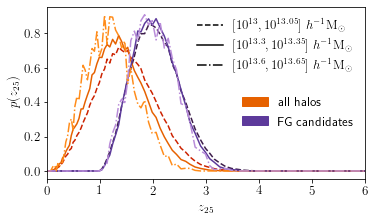

In [26]:
sim = haccytrees.Simulation.simulations['LastJourney']
zsteps = sim.step2z(np.array(sim.cosmotools_steps))
zmean = 0.5*(zsteps[1:] + zsteps[:-1])
dz = zsteps[:-1] - zsteps[1:] # z_previous - z_current

oranges = ["#CC2200", "#E66100", "#FF8C1A"]
purples = ["#3C1C4A", "#5D3A9B", "#B98CD9"]
bin_labels = [r"$[10^{13}, 10^{13.05}]$ $h^{-1}\mathrm{M}_\odot$", r"$[10^{13.3}, 10^{13.35}]$ $h^{-1}\mathrm{M}_\odot$", r"$[10^{13.6}, 10^{13.65}]$ $h^{-1}\mathrm{M}_\odot$"]
linestyles = iter(['--', '-', '-.'])

frac = 0.25
if frac == 0.5:
    label = r"$z_{50}$"
    name = "z50s"
    axline = 1
    right_lim = 2.5
elif frac == 0.8:
    label = r"$z_{80}$"
    name = "z80s"
    axline = 0.4
    right_lim = 2.5
elif frac == 0.04:
    label = r"$z_{4}$"
    name = "z04s"
    axline = None
    right_lim = 10
elif frac == 0.25:
    label = r"$z_{25}$"
    name = "z25s"
    axline = None
    right_lim = 6

fig, ax = plt.subplots(figsize = (5.4, 3.25))
fake_lines = []
for i, (this_halo_mask, this_fg_mask) in enumerate(zip(halo_masks, fg_masks)):
    current_linestyle = next(linestyles)

    # FG z50s
    fgs_idx = np.argwhere(this_fg_mask).T[0]
    fg_mainbranch_index, fg_mainbranch_masses = help_func_haccytrees.get_branches(fgs_idx, fg_forest)
    fg_z50s = help_func_haccytrees.get_zfracs(fg_forest, redshifts, fgs_idx, fg_mainbranch_masses, frac)
    # All z50s
    all_halos_idx = target_idx[this_halo_mask]
    all_mainbranch_index, all_mainbranch_masses = help_func_haccytrees.get_branches(all_halos_idx, forest)
    all_z50s = help_func_haccytrees.get_zfracs(forest, redshifts, all_halos_idx, all_mainbranch_masses, frac)

    # Loop over fossil statuses; plot histograms
    labels = iter(["all halos", "FG candidates"])
    #colors = iter(["#E66100", "#5D3A9B", "#009E73"])
    colors = iter([oranges[i], purples[i]])
    fossil_status_legend_handles = []
    #colors = iter([purples, blues])
    for z50s in [all_z50s, fg_z50s]:
        current_label = next(labels)
        current_color = next(colors)#[i]
        counts = np.zeros_like(dz)

        for j in range(1, len(zsteps)): # len(zsteps), maybe len(counts) instead?
            counts[j-1] = np.sum(np.isclose(z50s, zsteps[j], atol=1e-3)) #1e-5
        counts /= len(z50s)*dz # counts = probability that z50 is within dz
        ax.plot(zmean, counts, label=current_label, linestyle=current_linestyle, color=current_color)
        fossil_status_legend_handles.append(mpatches.Patch(color = current_color, label = current_label))

    # Legend for fossil status 
    if i == 1:
        #legend1 = ax.legend(loc = "center right")
        legend1 = ax.legend(handles = fossil_status_legend_handles, loc = "upper right", bbox_to_anchor = (1, 0.55), frameon = False)
    fake_lines.append(ax.plot([], [], c = 'k', linestyle = current_linestyle, label = bin_labels[i])[0])

ax.add_artist(legend1)
ax.set_ylabel("$p($" + label + "$)$") #?
ax.set_xlabel(label)
ax.set_xlim(left = 0, right = right_lim)
#ax.set_title("Last Journey: " + str(len(fg_forest['halo_index'])) + " fossils", fontsize = 14) # Kind of a cheating way...
if axline is not None:
    ax.axvline(axline, color = 'black', linestyle = ':')
# Legend for mass bins
ax.legend(fake_lines, bin_labels, loc = "upper right", frameon = False)
fig.tight_layout()
fig.savefig("full_lj_plots/" + name + "_dpdz_narrow_bins.png", bbox_inches='tight', pad_inches=0)

### More zfrac based explorations!


Stats for bin  13.0 to 13.05
How many z > thresh halos? (early forming):  65515
Average # major mergers:  1.8032053728153858
(Merging halos only) Average # major mergers:  1.9296809918165336
Number of rugs:  4294
Fraction: rugs to halos:  0.06554224223460277
How many z < thresh halos? (late forming):   203843
Average # major mergers:  1.434123320398542
(Merging halos only) Average # major mergers:  1.6417836684263731
Number of rugs:  25783
Fraction: rugs to halos:  0.12648459844095702
FRACTION: "early" forming/ "late" forming:  0.3213993122157739

Stats for bin  13.3 to 13.35
How many z > thresh halos? (early forming):  8946
Average # major mergers:  3.237536329085625
(Merging halos only) Average # major mergers:  3.2462452364940595
Number of rugs:  24
Fraction: rugs to halos:  0.0026827632461435278
How many z < thresh halos? (late forming):   27235
Average # major mergers:  2.8798971911143747
(Merging halos only) Average # major mergers:  2.908733543482292
Number of rugs:  270
Fracti

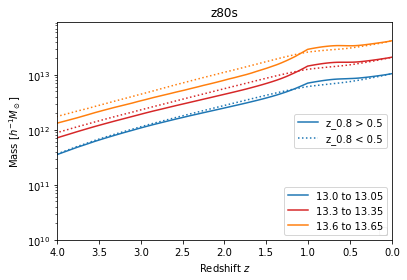

In [8]:
frac = 0.8
if frac == 0.5:
    threshold = 1
    name = "z50s"
elif frac == 0.8:
    threshold = 0.5
    name = "z80s"
    
zfrac_idx = []
zfrac_above_masses = []
zfrac_below_masses = []
colors = ["tab:blue", "tab:red", "tab:orange"]
bin_labels = ["13.0 to 13.05", "13.3 to 13.35", "13.6 to 13.65"]
labels = ["z_" + str(frac) + " > " + str(threshold), "z_" + str(frac) + " < " + str(threshold)]
fig, ax = plt.subplots()
fake_lines = []
for i, this_fg_mask in enumerate(fg_masks):
    current_color = colors[i]
    
    # Identify > and < halos
    fgs_idx = np.argwhere(this_fg_mask).T[0]
    fg_mainbranch_index, fg_mainbranch_masses = help_func_haccytrees.get_branches(fgs_idx, fg_forest)
    fg_mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(fg_forest, fg_progenitor_array, fg_mainbranch_index)
    fg_major_mergers = help_func_haccytrees.get_major_mergers(fg_mainbranch_mergers)
    fg_mm_count = help_func_haccytrees.count_major_mergers(fg_major_mergers)
    fg_z50s = help_func_haccytrees.get_zfracs(fg_forest, redshifts, fgs_idx, fg_mainbranch_masses, frac)
    zfrac_mask = fg_z50s  > threshold
    
    # Print stats
    print("\nStats for bin ", bin_labels[i])
    print("How many z > thresh halos? (early forming): ", len(zfrac_mask[zfrac_mask]))
    print("Average # major mergers: ", np.average(fg_mm_count[zfrac_mask]))
    print("(Merging halos only) Average # major mergers: ", np.average(fg_mm_count[zfrac_mask][fg_mm_count[zfrac_mask] > 0]))
    print("Number of rugs: ", len(fg_mm_count[zfrac_mask][fg_mm_count[zfrac_mask] == 0]))
    print("Fraction: rugs to halos: ", len(fg_mm_count[zfrac_mask][fg_mm_count[zfrac_mask] == 0])/len(zfrac_mask[zfrac_mask]))
    print("How many z < thresh halos? (late forming):  ", len(zfrac_mask[~zfrac_mask]))
    print("Average # major mergers: ", np.average(fg_mm_count[~zfrac_mask]))
    print("(Merging halos only) Average # major mergers: ", np.average(fg_mm_count[~zfrac_mask][fg_mm_count[~zfrac_mask] > 0]))
    print("Number of rugs: ", len(fg_mm_count[~zfrac_mask][fg_mm_count[~zfrac_mask] == 0]))
    print("Fraction: rugs to halos: ", len(fg_mm_count[~zfrac_mask][fg_mm_count[~zfrac_mask] == 0])/len(zfrac_mask[~zfrac_mask]))
    print("FRACTION: \"early\" forming/ \"late\" forming: ", len(zfrac_mask[zfrac_mask]) / len(zfrac_mask[~zfrac_mask]))
    
    # Compute average mass evolution history
    average_above = np.average(fg_mainbranch_masses[zfrac_mask], axis = 0) # is this the right axis?
    average_below = np.average(fg_mainbranch_masses[~zfrac_mask], axis = 0) # is this the right axis?
    
    # Plot mass evolution history
    fig, ax = help_func_haccytrees.plot_evol([average_above], cust_color = current_color, fig = fig, ax = ax, label = labels[0])
    fig, ax = help_func_haccytrees.plot_evol([average_below], cust_color = current_color, fig = fig, ax = ax, linestyle = ":", label = labels[1])
    
    # Legendary things
    if i == 0:
        legend1 = ax.legend(loc = "center right")
    fake_lines.append(ax.plot([],[], color = current_color)[0])
    
ax.legend(fake_lines, bin_labels, loc = "lower right")
ax.add_artist(legend1)
ax.set_title(name)
ax.set_ylim(bottom = 10**10)
ax.set_xlim(left = 4)
fig.savefig("full_lj_plots/" + name + "_mass_histories_zoomed.png")

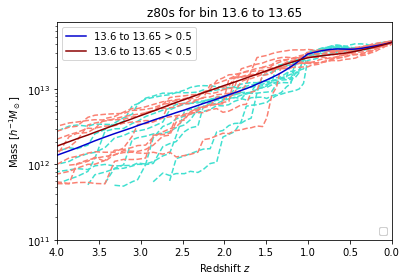

In [33]:
# Plot some mass evols for just one bin
frac = 0.8
if frac == 0.5:
    threshold = 1
    name = "z50s"
elif frac == 0.8:
    threshold = 0.5
    name = "z80s"
    
masknum = 2
if masknum == 0:
    name = "13.0 to 13.05"
    suffix = "13_0"
elif masknum == 1:
    name = "13.3 to 13.35"
    suffix = "13_3"
elif masknum == 2:
    name = "13.6 to 13.65"
    suffix = "13_6"
    
fig, ax = plt.subplots()

# Get branches and mask them
this_fg_mask = fg_masks[masknum]
fgs_idx = np.argwhere(this_fg_mask).T[0]
fg_mainbranch_index, fg_mainbranch_masses = help_func_haccytrees.get_branches(fgs_idx, fg_forest)
fg_mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(fg_forest, fg_progenitor_array, fg_mainbranch_index)
fg_major_mergers = help_func_haccytrees.get_major_mergers(fg_mainbranch_mergers)
fg_mm_count = help_func_haccytrees.count_major_mergers(fg_major_mergers)
fg_z50s = help_func_haccytrees.get_zfracs(fg_forest, redshifts, fgs_idx, fg_mainbranch_masses, frac)
zfrac_mask = fg_z50s  > threshold

# Take a sample
N = 10
np.random.seed(10)
fg_masses_above = np.random.choice(np.argwhere(zfrac_mask).T[0], N, replace = False)
fg_masses_below = np.random.choice(np.argwhere(~zfrac_mask).T[0], N, replace = False)
fig, ax = help_func_haccytrees.plot_evol(fg_mainbranch_masses[fg_masses_above], cust_color = "turquoise", fig = fig, ax = ax, linestyle = "--")
fig, ax = help_func_haccytrees.plot_evol(fg_mainbranch_masses[fg_masses_below], cust_color = "salmon", fig = fig, ax = ax, linestyle = "--")

# Compute averages
average_above = np.average(fg_mainbranch_masses[zfrac_mask], axis = 0)
average_below = np.average(fg_mainbranch_masses[~zfrac_mask], axis = 0)
fig, ax = help_func_haccytrees.plot_evol([average_above], fig = fig, ax = ax, cust_color = "mediumblue", label = name + " > " + str(threshold))
fig, ax = help_func_haccytrees.plot_evol([average_below], fig = fig, ax = ax, cust_color = "darkred", label = name + " < " + str(threshold))

ax.legend()
ax.set_xlim(left = 4)
ax.set_ylim(bottom = 1e11)
ax.set_title("z80s for bin " + name)
fig.savefig("full_lj_plots/z80s_mass_evols_bin_" + suffix + "_newseed.png")

# z80s/50s vs. other stats

### Relaxation vs. concentration by z50s

(269358,)
(269358,)
(60130,) (60130,)
(7500,) (60130,)
Plotting  0


ValueError: 'c' argument has 269358 elements, which is inconsistent with 'x' and 'y' with size 60130.

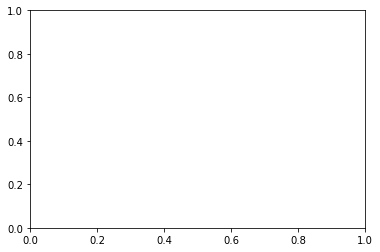

In [31]:
# One plot for each narrow mass bin
frac = 0.5
name = "z50s"
fg_target_masks = make_masks(forest, target_idx = fgs) # NOTICE THIS!!

titles = ["Mass bin: 13.0 to 13.05", "Mass bin: 13.3 to 13.35", "Mass bin: 13.6 to 13.65"]
suffixes = ["13_0", "13_3", "13_6"]
for i, (this_fg_mask, this_halo_mask) in enumerate(zip(fg_target_masks, halo_masks)): # is there another way to do this
    
    # Get those z50s
    fg_mainbranch_index, fg_mainbranch_masses = help_func_haccytrees.get_branches(fgs[this_fg_mask], forest) # Probably not really what I want...
    fg_z50s = help_func_haccytrees.get_zfracs(forest, redshifts, fgs[this_fg_mask], fg_mainbranch_masses, frac)
    fg_z50s_mask = fg_z50s > 1
    
    all_mainbranch_index, all_mainbranch_masses = help_func_haccytrees.get_branches(target_idx[this_halo_mask], forest)
    all_z50s = help_func_haccytrees.get_zfracs(forest, redshifts, target_idx, all_mainbranch_masses, frac)
    all_z50s_mask = all_z50s > 1
    print(all_z50s_mask.shape)
    print(data['sod_halo_cdelta'][target_idx][this_halo_mask].shape)
    
    # Turn that into colors
    fg_z50s_mask[fg_z50s_mask] = "red" # Alright, fine then. We'll use a dataframe after all, I guess... :P
    fg_z50s_mask[~fg_z50s_mask] = "blue"
    all_z50s_mask[all_z50s_mask] = "red"
    all_z50s_mask[~all_z50s_mask] = "blue"
    #cmap = colors.ListedColormap(['blue'])
    #cmap.set_bad(color='red')
    
    # Calculate concentrations and relaxations
    all_halos_cdeltas = data['sod_halo_cdelta'][target_idx][this_halo_mask]
    all_cdeltas_mask = all_halos_cdeltas > 0
    all_halos_relaxations = data['xoff_fof'][target_idx][this_halo_mask][all_cdeltas_mask]
    all_halos_cdeltas = all_halos_cdeltas[all_cdeltas_mask]
    #all_halos_relaxations = all_halos_relaxations[all_halos_relaxations > 0]
    print(all_halos_cdeltas.shape, all_halos_relaxations.shape)
    fg_cdeltas = data['sod_halo_cdelta'][fgs][this_fg_mask]
    fg_cdeltas_mask = fg_cdeltas > 0
    fg_relaxations = data['xoff_fof'][fgs][this_fg_mask][fg_cdeltas_mask]
    fg_cdeltas = fg_cdeltas[fg_cdeltas_mask]
    #fg_relaxations = fg_relaxations[fg_relaxations > 0]
    print(fg_cdeltas.shape, all_halos_relaxations.shape)
    
    # Plot
    print("Plotting ", i)
    fig, ax = plt.subplots()
    
    ax.scatter(all_halos_cdeltas, all_halos_relaxations, c = all_z50s_mask, label = "all halos", alpha = 0.2, marker = 'o') # c = all_z50s_mask,
    ax.scatter(fg_cdeltas, fg_relaxations, c = fg_z50s_mask, label = "fossil candidates", alpha = 0.2, marker = 's') # c = fg_z50s_mask
    ax.legend()
    ax.set_xlabel(r"$c_\Delta = r_\Delta/r_s$", fontsize = 14)
    ax.set_ylabel(r"$x_\mathrm{off} = \left| x_\mathrm{com} - x_\mathrm{pot} \right| \; / \; r_\Delta$", fontsize = 14)
    if i == 0:
        ax.set_xlim(right = 30)
    ax.set_title(titles[i], fontsize = 14)
    #fig.savefig("full_lj_plots/relaxation_vs_cdelta_" + suffixes[i] + ".png")

### Compare z80 categories to concentrations

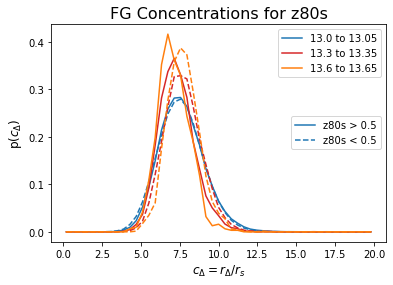

In [12]:
# Repeat for multiple bins
fig, ax = plt.subplots()

nbins = 50
frac = 0.8
if frac == 0.5:
    threshold = 1
    name = "z50s"
elif frac == 0.8:
    threshold = 0.5
    name = "z80s"
    
fake_lines = []
bin_labels = ["13.0 to 13.05", "13.3 to 13.35", "13.6 to 13.65"]
colors = iter(["tab:blue", "tab:red", "tab:orange"])

for i, this_fg_mask in enumerate(fg_masks): # fg_masks already account for fossil groups, z = 0, and mass bin
    current_color = next(colors)
    
    fgs_idx = np.argwhere(this_fg_mask).T[0]
    fg_mainbranch_index, fg_mainbranch_masses = help_func_haccytrees.get_branches(fgs_idx, fg_forest)
    fg_mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(fg_forest, fg_progenitor_array, fg_mainbranch_index)
    fg_major_mergers = help_func_haccytrees.get_major_mergers(fg_mainbranch_mergers)
    fg_mm_count = help_func_haccytrees.count_major_mergers(fg_major_mergers)
    fg_z50s = help_func_haccytrees.get_zfracs(fg_forest, redshifts, fgs_idx, fg_mainbranch_masses, frac)
    zfrac_mask = fg_z50s  > threshold
    
    #cdeltas_above = fg_forest['sod_halo_cdelta'][fgs_idx][zfrac_mask] # Did I do this correctly?
    #cdeltas_below = fg_forest['sod_halo_cdelta'][fgs_idx][~zfrac_mask]
    
    linestyles = iter(["-", "--"])
    labels = iter([name + " > " + str(threshold), name + " < " + str(threshold)])
    for this_zfrac_mask in [zfrac_mask, ~zfrac_mask]:
        current_linestyle = next(linestyles)
        current_label = next(labels)
        cdeltas = fg_forest['sod_halo_cdelta'][fgs_idx][this_zfrac_mask]
        hist = np.histogram(cdeltas, bins = np.linspace(0, 20, nbins), density = True)
        #hist = np.histogram(cdeltas, bins = np.linspace(0, 20, nbins), density = True) # np.min(cdeltas)
        bin_centers = (hist[1][:-1] + hist[1][1:]) / 2
        ax.plot(bin_centers, hist[0], linestyle = current_linestyle, color = current_color, label = current_label)
        if i == 0:
            legend1 = ax.legend(loc = "center right")
    fake_lines.append(ax.plot([],[], c = current_color)[0])
        
# Cosmetics
leg2 = ax.legend(fake_lines, bin_labels, loc='upper right')
ax.add_artist(legend1)
ax.set_xlabel(r"$c_\Delta = r_\Delta/r_s$", fontsize = 12)
ax.set_ylabel(r"p($c_\Delta$)", fontsize = 12)
ax.set_title("FG Concentrations for " + name, fontsize = 16)
fig.savefig("full_lj_plots/" + name + "_concentrations.png")

### Compare z80 categories to relaxations

tab:orange
tab:red
tab:blue


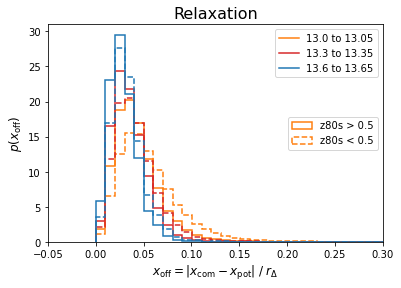

In [29]:
# Same for relaxations
fig, ax = plt.subplots()

nbins = 50
frac = 0.8
if frac == 0.5:
    threshold = 1
    name = "z50s"
elif frac == 0.8:
    threshold = 0.5
    name = "z80s"
    
fake_lines = []
bin_labels = ["13.0 to 13.05", "13.3 to 13.35", "13.6 to 13.65"]
colors = iter(["tab:orange", "tab:red", "tab:blue"])

for i, this_fg_mask in enumerate(fg_masks): # fg_masks already account for fossil groups, z = 0, and mass bin
    current_color = next(colors)
    print(current_color)
    
    fgs_idx = np.argwhere(this_fg_mask).T[0]
    fg_mainbranch_index, fg_mainbranch_masses = help_func_haccytrees.get_branches(fgs_idx, fg_forest)
    fg_mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(fg_forest, fg_progenitor_array, fg_mainbranch_index)
    fg_major_mergers = help_func_haccytrees.get_major_mergers(fg_mainbranch_mergers)
    fg_mm_count = help_func_haccytrees.count_major_mergers(fg_major_mergers)
    fg_z50s = help_func_haccytrees.get_zfracs(fg_forest, redshifts, fgs_idx, fg_mainbranch_masses, frac)
    zfrac_mask = fg_z50s  > threshold
    
    linestyles = iter(["-", "--"])
    labels = iter([name + " > " + str(threshold), name + " < " + str(threshold)])
    for this_zfrac_mask in [zfrac_mask, ~zfrac_mask]:
        current_linestyle = next(linestyles)
        current_label = next(labels)
        
        relaxations = fg_forest['xoff_fof'][fgs_idx][this_zfrac_mask]
        ax.hist(relaxations, np.linspace(0, 2, 200), histtype='step', density=True, linestyle = current_linestyle, label=current_label, color = current_color, linewidth = 1.5)
        
        if i == 0:
            legend1 = ax.legend(loc = "center right")
    fake_lines.append(ax.plot([],[], c = current_color)[0])
        
# Cosmetics
leg2 = ax.legend(fake_lines, bin_labels, loc='upper right')
ax.add_artist(legend1)
ax.set_xlabel(r"$x_\mathrm{off} = \left| x_\mathrm{com} - x_\mathrm{pot} \right| \; / \; r_\Delta$", fontsize = 12)
ax.set_ylabel(r'$p(x_\mathrm{off})$', fontsize = 12)
ax.set_xlim([-0.05,0.3])
ax.set_title("Relaxation", fontsize = 16)
fig.savefig("full_lj_plots/z80s_relaxations.png")

### z80s of rugs

In [ ]:
%%time
mlim = [1e13, 1e14] # Should yield 307993 from the random sample
xaxis = 'snap_nums'
absolute_threshold = True
threshold = 5e11
z_thresh = 1
norm_tf = False
restrict_mass = True
use_sigma = True
mrich_thresh = 0.1
# Go find yourself some fossil groups!
target_idx = help_func_haccytrees.find_halos(forest, mlim)
mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(target_idx, forest)
mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(forest, progenitor_array, mainbranch_index, absolute_threshold)
major_mergers = help_func_haccytrees.get_major_mergers(mainbranch_mergers, threshold)
lmm_redshifts, lmm_index = help_func_haccytrees.get_lmms(major_mergers, threshold)
fgs, rugs, mrich = help_func_haccytrees.find_specials(forest, mainbranch_index, major_mergers, lmm_redshifts, target_idx, z_thresh, mrich_thresh = mrich_thresh, restrict_mass = restrict_mass, use_sigma = use_sigma, mainbranch_masses = mainbranch_masses)
print(len(target_idx), " halos")
print(len(fgs), " fossils")
print(len(rugs), " rugs")
print(len(mrich), " merger rich halos")

finding merger rich halos, not restricting mass
how many fgs? 239281
how many rugs? 30077
how many rugs with mass above some thresh? 0
[    3563     5844    17434 ... 92186060 92188087 92192565]
[    3563     5844    17434 ... 92186060 92188087 92192565]
finding merger rich halos, not restricting mass
how many fgs? 35887
how many rugs? 294
how many rugs with mass above some thresh? 294
[  138223   431631   882930  1057177  1447033  2559585  2651871  3105592
  3406370  3567918  3757028  3808765  4619742  5334004  5449462  5948547
  6330736  7739141  7876415  7910969  7978172  8217860  8226641  8580088
  8592361  8713979  9673426  9847353  9882886  9926097 10270808 10703525
 11107348 11679177 11931765 12203487 12588809 12755104 13130987 13857638
 14013496 14618216 14648967 15320802 15541617 15631513 15700840 15828030
 15860854 16215359 16284084 16289908 16752301 17194774 17585597 17657874
 17787251 17983804 18106462 18895197 18915675 21699867 21842433 21990673
 22174058 23119956 23122063

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


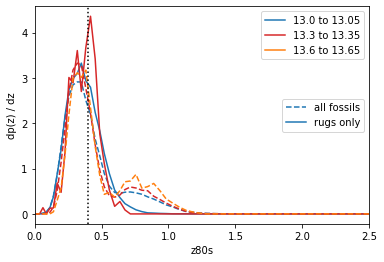

In [17]:
sim = haccytrees.Simulation.simulations['LastJourney']
zsteps = sim.step2z(np.array(sim.cosmotools_steps))
zmean = 0.5*(zsteps[1:] + zsteps[:-1])
dz = zsteps[:-1] - zsteps[1:] # z_previous - z_current

# Multiple bins
frac = 0.8
if frac == 0.5:
    name = "z50s"
    axline = 1
    right_lim = 2.5
elif frac == 0.8:
    name = "z80s"
    axline = 0.4
    right_lim = 2.5
    
colors = ["tab:blue", "tab:red", "tab:orange"]
bin_labels = ["13.0 to 13.05", "13.3 to 13.35", "13.6 to 13.65"]

fake_lines = []
fig, ax = plt.subplots()
for i, this_fg_mask in enumerate(fg_masks):
    
    # FG z50s
    fgs_idx = np.argwhere(this_fg_mask).T[0]
    fg_mainbranch_index, fg_mainbranch_masses = help_func_haccytrees.get_branches(fgs_idx, fg_forest)
    fg_z50s = help_func_haccytrees.get_zfracs(fg_forest, redshifts, fgs_idx, fg_mainbranch_masses, frac)
    zfrac_mask = fg_z50s  > threshold
    
    # Rugs only
    #if i == 0:
    fg_mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(fg_forest, fg_progenitor_array, fg_mainbranch_index)
    fg_major_mergers = help_func_haccytrees.get_major_mergers(fg_mainbranch_mergers)
    fg_lmm_redshifts, fg_lmm_index = help_func_haccytrees.get_lmms(fg_major_mergers)
    fgs, rugs, mrich = help_func_haccytrees.find_specials(fg_forest, fg_mainbranch_index, fg_major_mergers, fg_lmm_redshifts, fgs_idx)
    print("how many fgs?", len(fgs))
    print("how many rugs?", len(rugs))
    print("how many rugs with mass above some thresh?", len(rugs[fg_forest['tree_node_mass'][rugs] > 10**13.3]))
    fg_rug_masks = make_masks(fg_forest, target_idx = rugs) # was this ever necessary?
    print(rugs)
    #hist = np.histogram(fg_forest['tree_node_mass'][rugs], density = True)
    #bin_centers = (hist[1][:-1] + hist[1][1:])/2
    #ax.plot(bin_centers, hist[0])

    #fig, ax = plt.subplots()
    #print("True values in rug mask for bin ", i, ": ", len(fg_rug_masks[i][fg_rug_masks[i]]))
    fg_rugs_idx = rugs#np.argwhere(fg_rug_masks[i]).T[0] # this is inefficient
    print(fg_rugs_idx)
    fg_rugs_mainbranch_index, fg_rugs_mainbranch_masses = help_func_haccytrees.get_branches(fg_rugs_idx, fg_forest)    
    fg_rugs_z50s = help_func_haccytrees.get_zfracs(fg_forest, redshifts, fg_rugs_idx, fg_rugs_mainbranch_masses, frac)
    zfrac_rugs_mask = fg_rugs_z50s  > threshold

    # Plot histograms
    labels = iter(["all fossils", "rugs only"])
    linestyles = iter(["--", "-"])
    for z50s in [fg_z50s, fg_rugs_z50s]:
        current_label = next(labels)
        current_linestyle = next(linestyles)
        counts = np.zeros_like(dz)
    
        for j in range(1, len(zsteps)): # len(zsteps), maybe len(counts) instead?
            counts[j-1] = np.sum(np.isclose(z50s, zsteps[j], atol=1e-3)) #1e-5
        counts /= len(z50s)*dz # counts = probability that z50 is within dz
        
        ax.plot(zmean, counts, label=current_label, linestyle=current_linestyle, color=colors[i])
        
    if i == 0:
        legend1 = ax.legend(loc = "center right")
    fake_lines.append(ax.plot([], [], c = colors[i], label = bin_labels[i])[0])
    
ax.legend(fake_lines, bin_labels, loc = "upper right")
ax.add_artist(legend1)
ax.set_ylabel("dp(z) / dz") #?
ax.set_xlabel(name)
ax.set_xlim(left = 0, right = right_lim)
ax.axvline(axline, color = 'black', linestyle = ':')
fig.savefig("full_lj_plots/less_weird_z80_rugs.png")

In [52]:
print(np.argwhere(fgs_idx == 3563))
print(fgs_idx[11])

[[11]]
3563


### Auto/cross correlation functions and spectra

## Diffmah

In [ ]:
import diffmah
simulation = haccytrees.Simulation.simulations['LastJourney'] # read in a chunk of simulation
cosmic_time = simulation.cosmo.lookback_time(1e-10) - simulation.step2lookback(np.array(simulation.cosmotools_steps))

In [ ]:
# Calculate their parameters
def calc_subset_params(mainbranch_peakmass, size, cosmic_time, min_mass, non_fg_rugs_mrich):

    subset_params = np.zeros((size, 5))
    
    for ihalo in range(size):
        p_init, loss_data = get_loss_data(cosmic_time, np.log10(mainbranch_peakmass[ihalo]), np.log10(min_mass))
        n_step = 150
        _res = jax_adam_wrapper(log_mah_mse_loss, p_init, loss_data, n_step) # not sure where to get loss_func
        p_best, loss, loss_arr, params_arr, fit_terminates = _res
        logmp_fit, x0, lge, lgl = p_best
        logt0, u_k = loss_data[-2:] # logtmp = logt0
        t0 = 10 ** logt0 # present day age of the universe
        early_index = 10 ** lge
        late_index = 10 ** lgl
        fixed_k = DEFAULT_MAH_PARAMS["mah_k"]

        logt_fit = np.linspace(0, 1.15, 500)
        dmhdt_fit, log_mah_fit = _calc_halo_history(logt_fit, np.log10(t0), logmp_fit, x0, fixed_k, early_index, late_index) # should that tpeak now be tmp?
        subset_params[ihalo,:] = [logmp_fit, early_index, late_index, x0, non_fg_rugs_mrich[ihalo]]
    return subset_params

In [ ]:
# Did we already do this above?
# Go find some fossil groups! and other specials
absolute_threshold = True
threshold = 5e11
z_thresh = 1
restrict_mass = True
use_sigma = True
mrich_thresh = 0.1
mlim = [1e13, 1e14] # We're going to go ahead and call this a "very thin mass bin," so that we can treat M_0 as constant
target_idx = help_func_haccytrees.find_halos(forest, mlim)
mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(target_idx, forest)
mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(forest, progenitor_array, mainbranch_index, absolute_threshold)
major_mergers = help_func_haccytrees.get_major_mergers(mainbranch_mergers, threshold)
lmm_redshift, lmm_index = help_func_haccytrees.get_lmms(major_mergers, threshold)
fgs, rugs, mrich = help_func_haccytrees.find_specials(forest, mainbranch_index, major_mergers, lmm_redshift, target_idx, z_thresh, mrich_thresh = mrich_thresh, restrict_mass = restrict_mass, use_sigma = use_sigma, mainbranch_masses = mainbranch_masses)
mainbranch_peakmass = np.maximum.accumulate(mainbranch_masses, axis=1)
print(len(target_idx))
print(len(fgs))
print(len(rugs))
print(len(mrich))

## Substructure

## Is "fossilness" a phase?

# Old

In [ ]:
%%time
mask_z0 = fg_forest['snapnum'] == 100
fg_catalog = {k: fg_forest[k][mask_z0] for k in fg_forest.keys()} # forest data at z=0
s = np.argsort(fg_catalog['tree_node_index'])
fg_catalog = {k: fg_catalog[k][s] for k in fg_catalog.keys()}

@numba.jit(nopython=True)
def assign_fgs(full_tn_index, fg_tn_index): # Why is this so complicated just to produce 'index'? I guess it's actually not the same as 'index'
    n_full = len(full_tn_index)
    n_fg = len(fg_tn_index)
    c_full_idx = 0
    c_fg_idx = 0
    fg_index = np.empty(n_fg, dtype=np.int64)
    fg_index[:] = -1
    while c_full_idx < n_full and c_fg_idx < n_fg:
        if full_tn_index[c_full_idx] == fg_tn_index[c_fg_idx]:
            fg_index[c_fg_idx] = c_full_idx
            c_fg_idx += 1
        else:
            c_full_idx += 1
    return fg_index
fgs_idx = assign_fgs(fg_forest['tree_node_index'], fg_catalog['tree_node_index']) # probably not very useful for me tbh?